In [1]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

%matplotlib notebook

# Local Functions 

In [2]:
def TS_Describe_stats(data, dateCol, ValCol):
    mindate = data[dateCol].min()
    maxdate = data[dateCol].max()
    daterez = data[dateCol][1]-data[dateCol][0]
    minval = data[ValCol].min()
    maxval = data[ValCol].max()
    aveval = data[ValCol].mean()
    medval = data[ValCol].median()
    print("Date range = {} to {}".format(mindate, maxdate))
    print("Timestep is {}".format(daterez))
    print("Value range is {} to {}".format(minval, maxval))   
    print("Average value is {}".format(aveval))
    print("Median value is {}".format(medval)) 
    print('\n')


# Rain gauge file creation Function Obviously requires very specific input formatting

def make_rain_gag_file(Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, GageName, Resampling_timestep_Mins,
           Precip_column_Name, ImpPrecip_units="Inches"):

    Full_Frame = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 
    SliceFrame = Full_Frame[StartDate:EndDate]

    # Format date string for dumb file 
    SliceFrame_format = SliceFrame.copy()
    SliceFrame_format['da'] = SliceFrame_format.index.strftime('%Y %m %d %H %M')
    SliceFrame_format['datedumb'] = SliceFrame_format['da'].str[:]

    # Pull extranious columns 
    SliceFrame_format = SliceFrame_format[['datedumb', Precip_column_Name]]

    # Turn rain in to rain MM 
    if ImpPrecip_units == "Inches": 
        SliceFrame_format[Precip_column_Name+"_mm"] = SliceFrame_format[Precip_column_Name]*25.4 
        Precip_column_Name = Precip_column_Name+"_mm"
        

    # Round off the number of significant figs
    sigfigs = 3
    SliceFrame_format[Precip_column_Name] = SliceFrame_format[Precip_column_Name].round(sigfigs).apply(lambda x: 
                                                                                                 '{0:g}'.format(float(x)))
 
    # Put the GAGES card on EVery single row 
    SliceFrame_format["trash"] = "GAGES"

    # reorder columns 
    SliceFrame_format = SliceFrame_format[["trash", "datedumb", Precip_column_Name]]

    # Print it off to a txt file with no header, no index and space separator
    SliceFrame_format.to_csv(FileNamePlace, index=False, sep=' ', header = False) 

    # Remove dumb double quotes 
    with open(FileNamePlace,'r') as file:
        data = file.read()
        data = data.replace('"','')
    with open(FileNamePlace,'w') as file:    
        file.write(data)


    # Create the required header lines for WMS gag  files 
    AddLine = 'EVENT "Rain Gage" \nNRGAG 1 \nNRPDS {}\nCOORD {} {} "{}"'.format(len(SliceFrame_format),Lat, Lon, GageName)  

    with open(FileNamePlace, "r+") as f:
        old = f.read() # read everything in the file
        f.seek(0) # rewind
        f.write("{}\n".format(AddLine) + old) # write the new line before

    # Calculate the number of minutes to run the damn thing. 
    Total_Run_Length = Resampling_timestep_Mins*len(SliceFrame_format)
    print("Simulation time is {} minutes".format(Total_Run_Length))
    print("number of time rows is {}".format(len(SliceFrame_format)))

    
    return Total_Run_Length, SliceFrame_format


# Process streamflow datasets from da files 
def Isolate_Stream_Data(Input_Stream_File, StreamFlow_column_Name, StartDate, EndDate):
    Full_Frame = pd.read_csv(Input_Stream_File, index_col=0, parse_dates=True)
    SliceFrame = Full_Frame[StartDate:EndDate]

    return SliceFrame[[StreamFlow_column_Name]]



# Process outlet file from GSSHA into a pandas dataframe 
def process_otl_file(StartDate, OutletFile):

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("date", inplace=True)
    
    return OutHydro



def cmt_prama_jama(MapTableFile, Param, Val):
    with open(MapTableFile, 'r') as file :    # Read in the file 
        filedata = file.read()

    filedata = filedata.replace(Param, Val)  # Replace the target paramater(s)

    with open(MapTableFile, 'w') as file:   # Write the file out again
        file.write(filedata)
        
        
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

## Interfacing WMS models with Python utilities

- Step 1: Start by saving the complete and running WMS project in the RUN directory 
- Step 2: With the cell below, uncomment and pull out the fresh project file to the backup repository, where it will be housed for the run
- Step 3: Re-comment out the below cell and dont run again until its refreshed by a new WMS save


In [14]:
####### RUN THIS CELL ONLY WHEN SAVING A FRESH PROJECT FILE FROM WMS

#### Nuke out the WORKING_MODEL directory to start fresh
#for f in os.listdir("WORKING_MODEL"):  os.remove(os.path.join("WORKING_MODEL", f))

#### This will copy out the project files to the working directory  
#copy_tree("RUN", 'WORKING_MODEL')

#### Copy in GSSHA exe
#distutils.file_util.copy_file(os.path.join(".", "Data", "gssha.exe"), 'WORKING_MODEL')

#### Nuke out the RUN directory to start fresh
#for f in os.listdir("RUN"):  os.remove(os.path.join("RUN", f))

In [3]:
pwd


'C:\\Users\\CS\\Desktop\\Local_Project_Folders\\AdSci_Watershed\\Scripts\\Command_Line_Bootcamp'

# Setting up dynamic input rain and OBS streamflow data 
### Project variables to set 


In [4]:
# Priject File name from the WMS save 
PrjName = "test4"         

# Precip variables
Input_Precip_File   =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
Precip_column_Name       =  "rain_in"
ImpPrecip_units     =  "Inches"    # "Inches" or "mm"

# Event Variables 
StartDate   =  "2018-08-23 00:00"
EndDate     =    "2018-08-27 00:00"
Resampling_timestep_Mins = 30

# Rain Gauge Location info 
Lat  = 753354.0       # For Waihehe 753354,    # For WaiehuKou,"758000.0"
Lon  = 2314472.0       # For Waihehe 2314472,     # For WaiehuKou,"2315555.0" 
GageName    = "Gage2_Waihehe"


# Output Rain GAG file location 
FileNamePlace = os.path.join(".","RUN", "{}.gag".format(PrjName))

# Run the Rain Gauge Creation Function 
Total_Run_Length, Rain_Data_Frame = make_rain_gag_file(
    Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, 
    GageName, Resampling_timestep_Mins,
           Precip_column_Name, ImpPrecip_units="Inches")

Simulation time is 5790 minutes
number of time rows is 193


### Paramaterization time 

- First need to be sure that the correct parameter CODES from the Map_Table_Pram_Codes.csv' file were saved in WMS or were modified directly in the .cmt file in the WORKING MODEL Dir. 
- The Map_Table_Pram_Codes is set up to be able to direclty copy paste the codes into WMS based on one soil type per column 
- This function will modify the values to paramaterize in the {prj name}.cmt file 

In [5]:
pd.read_csv('Map_Table_Pram_Codes.csv', dtype=object)

,Parameter,Silty clay loam New,Bedrock New,Original Silty clay loam,Original Bedrock
0,Roughness,-10.000011,-10.000022,0.2,0.2
1,Hydro Conductivity (GA_inflf),-20.000011,-20.000022,0.37238,0.1
2,Capilary Head (GA_inflf),-20.000033,-20.000044,100,15
3,Porosity (GA_inflf),-20.000055,-20.000066,50,30
4,Pore Dist Index (GA_inflf),-20.000077,-20.000088,1.8,1.8
5,Resid Sat (GA_inflf),-20.000099,-20.001111,0.06,0.02
6,Field Capacity (GA_inflf),-20.001122,-20.001133,0.252,0.283
7,Wilting Point (GA_inflf),-20.001144,-20.001155,0.094,0.164
8,Soil Moisture,-30.000011,-30.000022,0.25,0.15


In [6]:
# the location of the .cmt file to modify 
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format("test4"))

- So note that this Cell is needed to run because any and all parameters coming out of WMS should be input as codes.  This block will change the codes back to some default number, the "original" value in the Map_Table_Pram_Codes.csv.   
- When actually doing parameterization or whatnot another block needs to be written to isolate whatever parameter is being tested and to change all to their value and then 

In [7]:
# the location of the .cmt file to modify 
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format(PrjName))

# Read in the parameter table 
Parameter_CodeBook = pd.read_csv('Map_Table_Pram_Codes.csv', dtype=object)

for i in Parameter_CodeBook.index:
    
    # Write in all the Parameters for the 'Silty clay loam soils'
    Param = Parameter_CodeBook['Silty clay loam New'][i]
    Val = Parameter_CodeBook['Original Silty clay loam'][i]
    # Do the actual overwriting 
    cmt_prama_jama(MapTableFile, Param, Val)
    
    
    # Write in all the Parameters for the 'Bedrock soils'
    Param = Parameter_CodeBook['Bedrock New'][i]
    Val = Parameter_CodeBook['Original Bedrock'][i]
    # Do the actual overwriting 
    cmt_prama_jama(MapTableFile, Param, Val)

### Create streamflow observations at the Run's Date-range 

In [8]:
# Stream Data Variables for Waihehe
Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
# Run function to create stream OBS dataframe 
WaiheheCFS = Isolate_Stream_Data(Input_Stream_File, "WaiheheFlow", StartDate, EndDate)

# Stream Data Variables for Wailuku
Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
# Run function to create stream OBS dataframe 
WailukuCFS = Isolate_Stream_Data(Input_Stream_File, "Wailuku_KepaniwaiFlow", StartDate, EndDate)

#### Run da model 

<IPython.core.display.Javascript object>


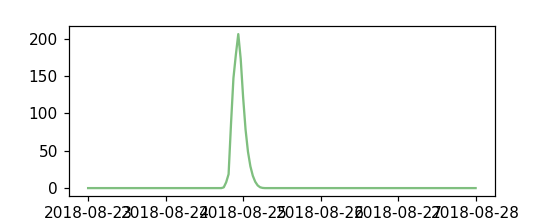

In [12]:
# Run the GSSHA process in the command line 
os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
os.chdir(os.path.join(".."))                # Change back out of run directory 

# Process the Run's Output hydrograph into a dataframe 
OutletFile = os.path.join("RUN", PrjName)+".otl"
OutHydro = process_otl_file(StartDate, OutletFile)

# Plot it quick 
fig, ax = plt.subplots(figsize=(5, 2)); ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")


##### Calculating NSE from predictions and targets 
- NOTES: 
- the 2 arrays need to be the same size, thus resampling may be needed. Might write a code to resample perfectly based on strange timesteps someday
- 

<IPython.core.display.Javascript object>


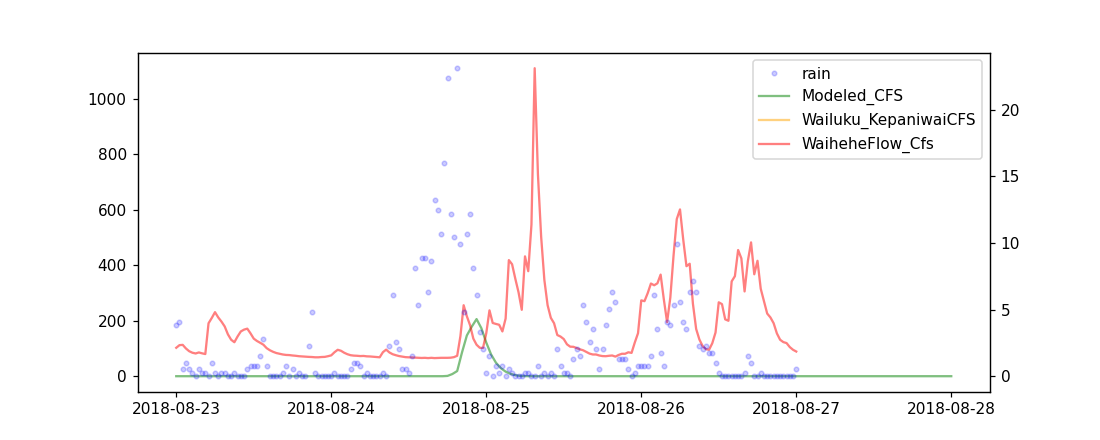

The NSE is -396.94500309819966


In [13]:
# visualize outputs 
fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()


Rain_Data_Frame['rain_in_mm'] = Rain_Data_Frame['rain_in_mm'].astype(float)  # for some reason rainfall comes out as strings

lns0 = ax2.plot(Rain_Data_Frame['rain_in_mm'], '.', c='b', alpha=0.2, label="rain")
lns1 = ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")
lns2 = ax.plot(WailukuCFS["Wailuku_KepaniwaiFlow"], '-', c='orange', alpha=0.5, label="Wailuku_KepaniwaiCFS")
lns3 = ax.plot(WaiheheCFS["WaiheheFlow"], '-', c='r', alpha=0.5, label="WaiheheFlow_Cfs")

# adding a legend for the twiny part....
lns = lns0+lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


# NSE calculation          
predictions = OutHydro['CFS'].to_numpy()
targets = WaiheheCFS.resample('60T').mean().to_numpy()
NSE_stat = nse(predictions, np.nan_to_num(targets))
print("The NSE is {}".format(NSE_stat))

# Recycle Bin ode 

In [ ]:
### Run the model vanilla 

#### Nuke out the RUN directory to start fresh
for f in os.listdir("RUN"):  os.remove(os.path.join("RUN", f))

# Shuttle out and copy the model files to a repository for future runs
copy_tree('WORKING_MODEL', "RUN")


# Run the GSSHA process in the command line 
os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
os.chdir(os.path.join(".."))                # Change back out of run directory 



### Process output hydrograph into something useful 

# Create the start time object to enumerate the number of minutes in the outlet file 
StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')


# read in the outlet file 
OutletFile = os.path.join("RUN", PrjName)+".otl"
OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)

# da magic: Turn stupid minutes into useful datetime objects 
OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))

# Set the index to the date
OutHydro.set_index("date", inplace=True)








# Set up parameters 
ClayRoughness     = "99999999"
BedrockRoughness  = "88888888"

ClayRoughnessVal    = "0.032000"
BedrockRoughnessVal = "0.025000"

# Here just in case the location of the .cmt file is changed
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format(PrjName))







OutHydro.reset_index(inplace=True)
TS_Describe_stats(OutHydro, "date", "CFS")


WaiheheCFS.reset_index(inplace=True)
TS_Describe_stats(WaiheheCFS, "datetime", "WaiheheFlow")

OutHydro = OutHydro.set_index('date')
WaiheheCFS = WaiheheCFS.set_index("datetime")
OutHydro.reset_index(inplace=True)
TS_Describe_stats(OutHydro, "date", "CFS")













BedrockRoughnessList = ["0.002", "0.02", "0.2", "0.99"]

for i in BedrockRoughnessList:
    
    #### Nuke out the RUN directory to start fresh
    for f in os.listdir("RUN"):  os.remove(os.path.join("RUN", f))
    # Shuttle out and copy the model files to a repository for future runs
    copy_tree('WORKING_MODEL', "RUN")
    
    
    cmt_prama_jama(MapTableFile, BedrockRoughness, i)

    # Run the GSSHA process in the command line 
    os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
    subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
    os.chdir(os.path.join(".."))                # Change back out of run directory 

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')


    # read in the outlet file 
    OutletFile = os.path.join("RUN", PrjName)+".otl"
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)

    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))

    # Set the index to the date
    OutHydro.set_index("date", inplace=True)

    fig, ax = plt.subplots(figsize=(10, 4))
    ax2 = ax.twinx()

    lns1 = ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")
